In [2]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')

import numpy as np
from sklearn.utils import check_random_state
from kernellib.dependence import get_sample_data, HSIC
from kernellib.kernels import estimate_length_scale, rbf_kernel
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate Sample Data

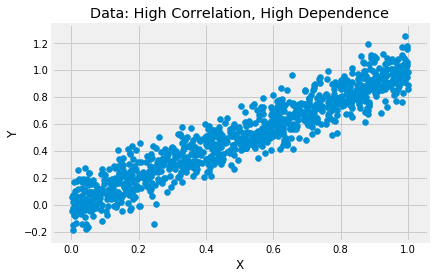

In [3]:
X, Y = get_sample_data(dataset='hh', num_points=1000, seed=1234, noise=0.1)

n_samples, d_dimensions = X.shape

fig, ax = plt.subplots()

ax.scatter(X, Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data: High Correlation, High Dependence')
plt.show()

## HSIC Algorithm

### Step I: Compute Kernel

#### RBF Kernel

In [4]:
# Estimate Length_scale Parameters
sub_sample   = 1000
method       = 'median'
seed         = 1234

sigma_x = estimate_length_scale(
    X, 
    sub_sample=sub_sample,
    method=method,
    random_state=seed
)

sigma_y = estimate_length_scale(
    Y, 
    sub_sample=sub_sample,
    method=method,
    random_state=seed
)

print(f"\u03BB_x = {sigma_x:.4f}")
print(f"\u03BB_y = {sigma_x:.4f}")

λ_x = 0.2119
λ_y = 0.2119


In [5]:
# Calculate Kernel
K_x = rbf_kernel(X, length_scale=sigma_x)
K_y = rbf_kernel(Y, length_scale=sigma_y)

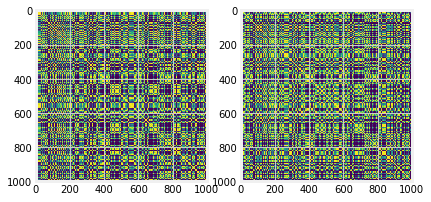

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2)

p0 = ax[0].imshow(K_x, )
p1 = ax[1].imshow(K_y, )

plt.show()

#### Linear Kernel

In [49]:
K_x = X @ X.T 
K_y = Y @ Y.T 

### Step II: Center Kernels

Kernel Centerer:
$$\text{H}=I- \left( \frac{1}{N}\right)\mathbb{1}$$

In [50]:
# Kernel Centerer
H = np.eye(n_samples) - (1 / n_samples) * np.ones(n_samples)

# Center the Kernels (X, Y)
K_xc = K_x @ H
K_yc = K_y @ H

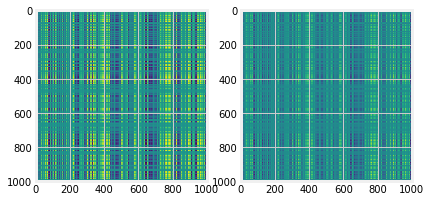

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2)

p0 = ax[0].imshow(K_xc, )
p1 = ax[1].imshow(K_yc, )

plt.show()

### Step III: Calculate HSIC Value

$$HSIC(\mathcal{F}, \mathcal{G}, \mathbb{P}_{xy})=\text{factor} * \text{Tr}(HK_xHK_y)$$

where:
* factor $=\frac{1}{(N - 1)^2}$

In [52]:
factor = 1 / (n_samples - 1)**2

hsic_value = factor * np.trace(K_xc @ K_yc)

print(hsic_value)

0.007502595866950361


#### Calculate HSIC Speedup

In [53]:
hsic_value = factor * np.einsum('ji,ij->', K_xc, K_yc)
print(hsic_value)

0.007502595866950365


In [54]:
%timeit np.trace(K_xc @ K_yc)
%timeit np.einsum('ji,ij->', K_xc, K_yc)

3.54 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.15 ms ± 375 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## HSIC Function (Kernellib)

In [55]:
# HSIC Method Parameters
kernel       = 'lin'
sub_sample   = 1000
X_method     = 'median'
Y_method     = 'median'
seed         = 1234

# Initiate HSIC Model
hsic_model = HSIC(
    kernel=kernel,
    X_stat=X_method,
    Y_stat=Y_method,
    sub_sample=sub_sample,
    random_state=seed
)

# Fit HSIC Model to Data
hsic_model.fit(X, Y);

# Display Results
print(f"\u03BB_x: {hsic_model.sigma_x:.4f}")
print(f"\u03BB_y: {hsic_model.sigma_y:.4f}")
print(f"HSIC value: {hsic_model.hsic_value:.5f}")

TypeError: unsupported format string passed to NoneType.__format__

In [47]:
%timeit hsic_model.fit(X, Y)

20.7 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
